In [1]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

### SVD для сжатия данных

**Загрузим картинку**

In [7]:
img = io.imread('https://i.pinimg.com/originals/c4/06/65/c40665c475735cf7436a12b9995998b2.jpg')
img = resize(rgb2gray(img), np.array(img.shape) / 5)[:, :, 0]
img.shape

(360, 576)

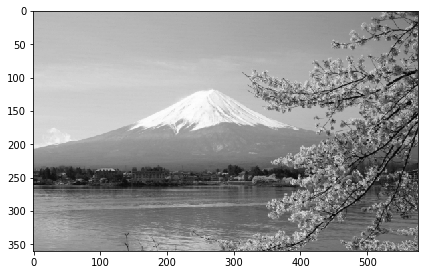

In [10]:
io.imshow(img);

**Применим SVD**

In [11]:
def svd(A):
    ATA = A.T @ A
    
    sigmas_sq, V = np.linalg.eig(ATA)
    VT = V.T
    
    Sigma = np.diag(sigmas_sq) ** 0.5
    
    assert np.allclose(V.dot(np.diag(sigmas_sq)).dot(VT), ATA)
    
    U = (A @ V) / (sigmas_sq.reshape(1, -1)**0.5)
    
    assert np.allclose(A, U @ Sigma @ VT)
    
    return U, Sigma, VT

In [13]:
U, Sigma, VT = svd(img)

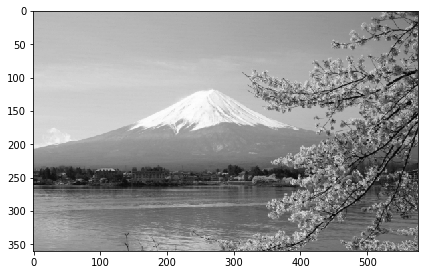

In [14]:
io.imshow(np.real(U @ Sigma @ VT));

**Оставим $k$ компонент**

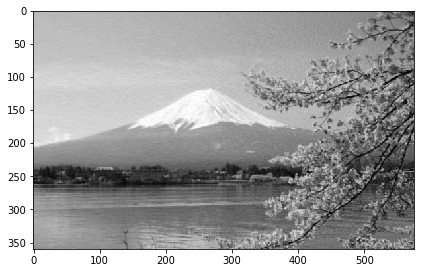

In [116]:
k = 100

img_k_components = np.real(U[:, :k] @ Sigma[:k, :k] @ VT[:k, :])

io.imshow(np.clip(img_k_components, 0, 1));

In [117]:
np.prod(U[:, :k].shape) + k + np.prod(VT[:k, :].shape)

93700

In [118]:
np.prod(A.shape)

207360

### SVD для анализа и получения сжатых векторых представления
### (на примере тематического моделирования)

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords

In [2]:
data = pd.read_csv('lenta-ru-news.csv')   

words = re.compile('\w+')
stops = set(stopwords.words('russian'))

C:\Users\leshanbog\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
def preprocess_text(doc):
    return ' '.join([x for x in re.findall(words, doc.lower()) if x not in stops])

N = 20000
documents = [preprocess_text(doc) for doc in data['text'][:N]]

In [38]:
from collections import Counter

most_popular_words = Counter()
for doc in documents:
    most_popular_words.update(doc.split())
    
M = 2000
most_popular_words = set([w for w, _ in most_popular_words.most_common(M)])

In [39]:
word_to_ind = {w: i for i, w in enumerate(most_popular_words)}
ind_to_word = {i: w for w, i in word_to_ind.items()}

In [40]:
A = np.zeros((N, M))

for i in range(N):
    for w in documents[i].split():
        if w in most_popular_words:
            A[i, word_to_ind[w]] += 1

    A[i] /= max(1, A[i].sum())

In [23]:
import numpy as np

In [41]:
U, Sigma, VT = np.linalg.svd(A)

In [42]:
U.shape

(20000, 20000)

In [43]:
[ind_to_word[i] for i in np.argsort(VT.T[:, 0])[-15:]]

['сессии',
 'компьютерной',
 'жириновский',
 'сайты',
 'яблока',
 'вирус',
 'бюллетеней',
 'доступа',
 'овр',
 'internet',
 'yahoo',
 'пасе',
 'имен',
 'избирательного',
 'web']

In [44]:
[ind_to_word[i] for i in np.argsort(VT.T[:, 1])[-15:]]

['компании',
 '7',
 'миллионов',
 'это',
 '5',
 '0',
 'году',
 '4',
 'сша',
 '3',
 '2',
 'долларов',
 'года',
 '1',
 '6']

In [45]:
[ind_to_word[i] for i in np.argsort(VT.T[:, 2])[-15:]]

['подчеркнул',
 'правительства',
 'риа',
 'новости',
 'отметил',
 'словам',
 'сообщил',
 'президент',
 'года',
 'владимир',
 'заявил',
 'рф',
 'путин',
 'президента',
 'россии']